[View in Colaboratory](https://colab.research.google.com/github/JozeeLin/google-tensorflow-exercise/blob/master/feature_crosses.ipynb)

# 特征组合(Feature Crosses)
## 对非线性规律进行编码(多项式)
特征组合是指通过将两个或多个输入特征相乘来对特征空间中的非线性规律进行编码的合成特征。"cross"(组合)这一术语来自cross product(向量积)。我们通过将$x_1$和$x_2$组合来创建一个名为$x_3$的特征组合。$x_3 = x_1x_2$


像处理任何其他特征一样来处理这个新建的$x_3$特征组合。线性公式变为:

$y = b+w_1x_1+w_2x_2+w_3x_3$

线性算法可以算出$w_3$的权重，就像算出$w_1$和$w_2$的权重一样。换言之，虽然$w_3$表示非线性信息，但您不需要改变线性模型的训练方式来确定$w_3$的值。
### 特征组合的种类
我们可以创建很多不同种类的特征组合。例如:
- [A X B]:将两个特征的值相乘形成的特征组合
- [A X B X C X D X E]:将五个特征的值相乘形成的特征组合
- [A X A]:对单个特征的值求平方形成的特征组合

通过采用随机梯度下降法，可以有效的训练线性模型。因此，在使用扩展的线性模型时辅以特征组合一直都是训练大规模数据集的有效方法。
## 组合独热矢量
前面介绍了如何对两个单独的浮点特征进行特征组合。在实践中，机器学习模型很少会组合连续特征。不过，机器学习模型却经常组合独热特征矢量的特征组合视为逻辑连接。

例如，假设我们具有以下两个特征:国家/地区和语言。对每个特征进行独热编码会生成具有二元特征的矢量，这些二元特征可解读为**country=USA,country=France或language=English，language=Spanish**。

然后，如果您对这些独热编码进行特征组合，则会得到可解读为逻辑连接的二元特征，如下所示:**country:usa AND language:spanish**

再举个例子，假设您对纬度和经度进行分箱，获得单独的独热5元素特征矢量。例如，指定的纬度和经度可以表示如下:

  binned_latitude = [0, 0, 0, 1, 0]
  
  binned_longitude = [0, 1, 0, 0, 0]
  
假设对这两个特征矢量创建了特征组合:

binned_latitude X binned_longitude

此特征组合是一个25元素独热矢量(24个0和1个1)。该组合中的单个1表示纬度和经度的特定连接。然后，您的模型就可以了解到有关这种连接的特定关联性。

假设我们更粗略的对纬度和经度进行分箱，如下所示:

```
binned_latitude(lat) = [
  0  < lat <= 10
  10 < lat <= 20
  20 < lat <= 30
]

binned_longitude(lon) = [
  0  < lon <= 15
  15 < lon <= 30
]
```
针对这些粗略分箱创建特征组合会生成具有以下含义的合成特征:
```
binned_latitude_X_longitude(lat, lon) = [
  0  < lat <= 10 AND 0  < lon <= 15
  0  < lat <= 10 AND 15 < lon <= 30
  10 < lat <= 20 AND 0  < lon <= 15
  10 < lat <= 20 AND 15 < lon <= 30
  20 < lat <= 30 AND 0  < lon <= 15
  20 < lat <= 30 AND 15 < lon <= 30
]
```
现在，假设我们的模型需要根据以下两个特征来预测狗主人对狗狗的满意程度:
- 行为类型(吠叫、叫、偎依等)
- 时段

如果我们根据这两个特征构建以下特征组合:

[behavior type X time of day]

我们最终获得的预测能力将远远超过任一特征单独的预测能力。例如，如果狗狗在下午5点主人下班回来时(快乐地)叫喊，可能表示对主人满意度的正面预测结果。如果狗狗在凌晨3点主人熟睡时(也许痛苦地)哀叫，可能表示对主人满意度的强烈负面预测结果。

对大规模数据集使用特征组合是学习高度复杂模型的一种有效策略。神经网络可提供另一种策略。

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2650.6,541.1,1432.9,502.6,3.9,2.0
std,2.1,2.0,12.6,2221.0,426.8,1161.8,390.1,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,298.0,792.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2133.0,435.0,1169.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3145.2,648.0,1725.0,605.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2626.9,535.5,1421.7,497.8,3.9,2.0
std,2.1,2.0,12.6,2078.3,408.6,1113.7,370.9,1.9,1.2
min,32.5,-124.3,2.0,11.0,3.0,8.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1464.8,294.0,783.0,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2112.0,430.0,1160.0,405.5,3.5,1.9
75%,37.7,-118.0,37.0,3165.2,650.0,1715.2,607.0,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.0
std,116.2
min,15.0
25%,118.9
50%,179.6
75%,264.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.0
std,115.5
min,22.5
25%,120.8
50%,182.0
75%,265.2
max,500.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 ## FTRL 优化算法

高维度线性模型可受益于使用一种基于梯度的优化方法，叫做 FTRL。该算法的优势是针对不同系数以不同方式调整学习速率，如果某些特征很少采用非零值，该算法可能比较实用（也非常适合支持 L1 正则化）。我们可以使用 [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer) 来应用 FTRL。

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 206.24
  period 01 : 161.59
  period 02 : 122.88
  period 03 : 140.01
  period 04 : 138.16
  period 05 : 132.21
  period 06 : 137.48
  period 07 : 130.60
  period 08 : 132.56
  period 09 : 121.25
Model training finished.


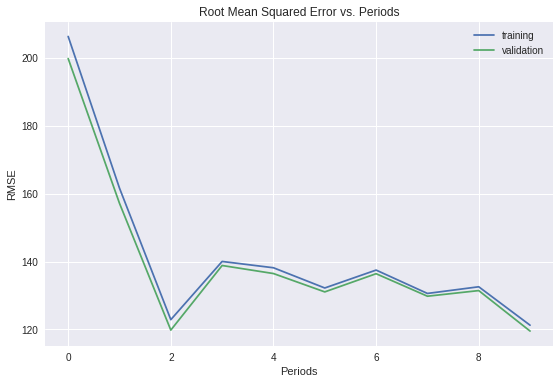

In [9]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets.
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
  households, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["households"], 7))

# Divide longitude into 10 buckets.
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
  longitude, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["longitude"], 10))

 ## 任务 1：使用分桶特征列训练模型
**将我们示例中的所有实值特征进行分桶，训练模型，然后查看结果是否有所改善。**

在前面的代码块中，两个实值列（即 `households` 和 `longitude`）已被转换为分桶特征列。您的任务是对其余的列进行分桶，然后运行代码来训练模型。您可以采用各种启发法来确定分桶的范围。本练习使用了分位数技巧，通过这种方式选择分桶边界后，每个分桶将包含相同数量的样本。

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 169.56
  period 01 : 143.36
  period 02 : 126.93
  period 03 : 115.85
  period 04 : 108.01
  period 05 : 102.25
  period 06 : 97.80
  period 07 : 94.23
  period 08 : 91.40
  period 09 : 89.08
Model training finished.


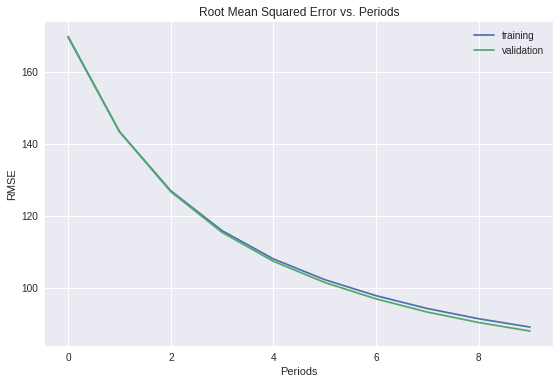

In [12]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 任务 2：使用特征组合训练模型

**在模型中添加 `longitude` 与 `latitude` 的特征组合，训练模型，然后确定结果是否有所改善。**

请参阅有关 [`crossed_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) 的 TensorFlow API 文档，了解如何为您的组合构建特征列。`hash_bucket_size` 可以设为 `1000`。

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 163.46
  period 01 : 135.41
  period 02 : 118.55
  period 03 : 107.38
  period 04 : 99.65
  period 05 : 94.02
  period 06 : 89.60
  period 07 : 86.10
  period 08 : 83.27
  period 09 : 80.87
Model training finished.


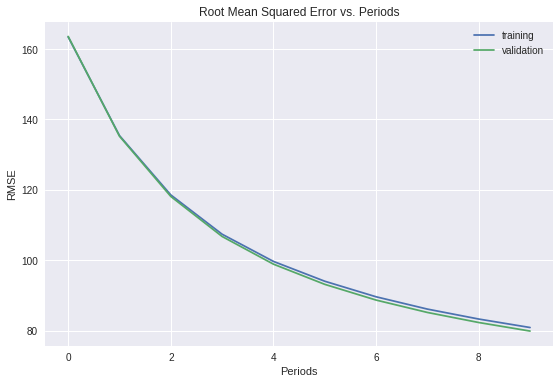

In [14]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 可选挑战：尝试更多合成特征

到目前为止，我们已经尝试了简单的分桶列和特征组合，但还有更多组合有可能会改进结果。例如，您可以组合多个列。如果改变分桶的数量，会出现什么情况？您还能想到哪些其他的合成特征？它们能否改进模型效果？